<a href="https://colab.research.google.com/github/samueldatasci/Modelling_biosystems/blob/main/session2_students_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install control
!pip install osysid --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 549.6/549.6 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for osysid: filename=osysid-0.1.9-py3-none-any.whl size=9525 sha256=4f3b58e0c201920df57d63dec07e45e01e5f93acc0a6ed2f69827f3f7771be72
  Stored in directory: /root/.cache/pip/wheels/dd/a4/69/f904debe11437f09342b4635c13af652a35adac7d38b669d9b
Successfully built osysid


In [2]:
import numpy as np
import numpy.random as random
from scipy import signal
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse
import matplotlib.pyplot as plt
import control.matlab as cnt
import control
import pandas as pd
import osysid

In [3]:
def r_2(y, y_hat):

  y_mean = np.mean(y)
  sst = np.sum((y - y_mean) ** 2)
  ssr = np.sum((y - y_hat) ** 2)
  r_squared = 1 - (ssr / sst)

  return r_squared

In [4]:
def rmse(y, y_hat):

  rmse = np.sqrt(mse(y, y_hat))
  y_range = np.max(y) - np.min(y)
  nrmse = rmse / y_range

  return nrmse

In [5]:
def aic(y, y_hat, p, q):

  MSE = mse(y, y_hat)
  k = p + q + 1
  n = len(y)
  aic = n * np.log(MSE) + 2 * k

  return aic

In [6]:
def dataloader(data, na, nb, d):

    # Initialize empty arrays for lagged features
    y = data['y']
    u = data['u']
    X = pd.DataFrame()


    # Create lagged features for output ('a' parameters)
    for i in range(1,na+1):
        X['y-{}'.format(i)] = y.shift(i)
    # Create lagged features for input ('b' parameters)
    for i in range(0,nb):
        X['u-{}'.format(i + d)] = u.shift(i + d)



    X = X.iloc[max(na,nb+d):]
    # Set the target values
    y = y[max(na,nb+d):]

    X.reset_index(drop=True, inplace=True)
    y.reset_index(drop=True, inplace=True)
    return X, y

Step 0: Generate and plot the artifical data

Text(0.5, 1.0, 'Noisy signal')

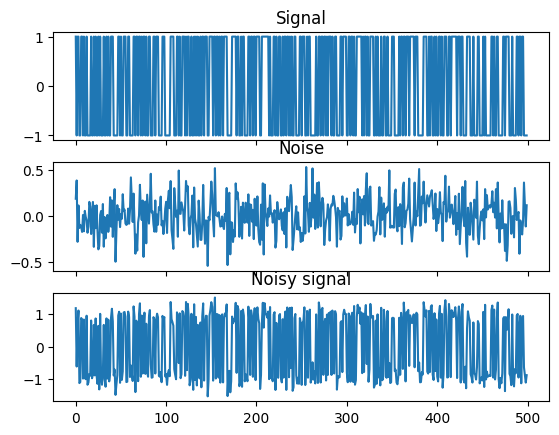

In [7]:
np.random.seed(42)  # You can choose any integer as the seed


# # 0.1 Generate and plot the artifical input

# n = 500
# T = np.arange(n)
# s = np.sign(np.random.randn(n)) # Returns an element-wise indication of the sign of a number, the sign function returns -1 if x < 0, 0 if x==0, 1 if x > 0
# # e = ... noise, random.randn(numberOfColumns, numberOfRows): Return a sample (or samples) in a given shape from the “standard normal” distribution
# e = random.randn(n)
# print(e.shape)
# # u = ... noisy signal (combination of clean and noisy)
# u = s + e
# print(u.shape)


n = 500
dt = 1
T = np.linspace(0, (n-1)*dt, n)
s = np.sign(random.randn(n,1))
e = random.randn(n,1) / 5
u = s + e


# Plot the artifical data (uncomment and adjust to plot)
f, ax = plt.subplots(3, 1, sharex=True)
ax[0].plot(T,s)
ax[0].set_title('Signal')
ax[1].plot(T,e)
ax[1].set_title('Noise')
ax[2].plot(T,u)
ax[2].set_title('Noisy signal')

Generate the transfer function using the following formula (the delay d is subtracted in the index of the u terms of the b parameters)

e.g. b1 * u(k-1-d)

Note: to visualize the formula use dark mode in settings

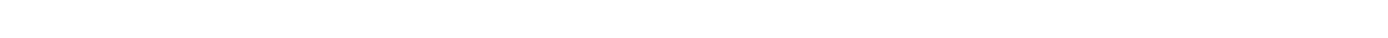

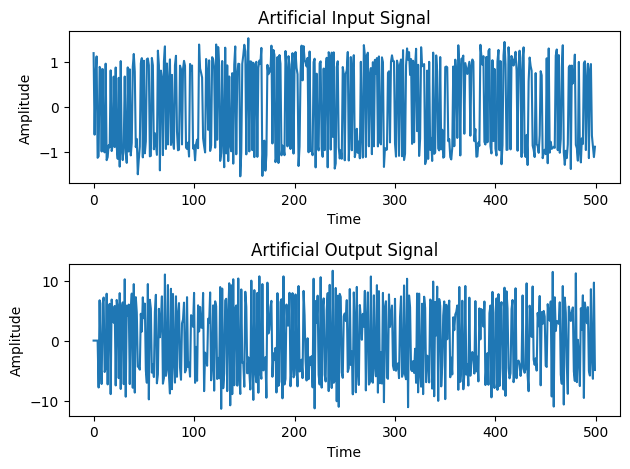

In [8]:
# 0.2 Test: Simulate and plot the artificial output
# Already defined parameters for you
a1 = 0.2
b0 = 1.6
b1 = -5.9
d = 4
number_a = 1
number_b = 2
e = np.random.randn(n, 1) * np.sqrt(0.16) # e is added noise

# Now, create a model with the specified parameters
# Start with an empty vector for y using zeros((size,dim))
y = np.zeros((n,1)) #[n]

# Simulate the output
for k in range(max(number_b + d, number_a) - 1, n):
    y[k] = (-a1*y[k-1]) + b0*u[k-d] + b1*u[k-1-d] + e[k]              # use the formula

# Plot the input and output signals
plt.figure()
plt.subplot(2, 1, 1)
plt.plot(T,u)
plt.title('Artificial Input Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.subplot(2, 1, 2)
plt.plot(T,y)
plt.title('Artificial Output Signal')
plt.xlabel('Time')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()


Step 1: Data preparation

In [9]:
# 0.3 Prepare data
# use reshape(-1) to reshape the array into a 1D array
# create/transform the pandas dataframe so that each column corresponds to a variable (exogenous 'u' & endogenous 'y')

data_u = u.reshape(-1)
data_y = y.reshape(-1)
data = pd.DataFrame([data_u,data_y]).T
data.columns = ['u', 'y']

# Inspect training data
#OR
data1 = pd.DataFrame()
data1['u'] = data_u
data1['y'] = data_y
data1
#plt.plot(data1)

,u,y
0,1.185236,0.000000
1,-0.618117,0.000000
2,0.720286,0.000000
3,1.112594,0.000000
4,-1.130129,0.000000
...,...,...
495,0.943780,8.569848
496,-0.640463,-2.859218
497,-0.871831,-6.371376
498,-1.114236,9.668123


Lets imagine the above defined data is real, try to identify which model is underlying the data.

To do so, check the parameters of the model structure that best fit the data and look up if they match the structure and values we used (remember the sign convention about the a and b parameters, the autoregressive (endogenous) parameters a have flipped sign)

Step 2: Parameter estimation

In [21]:
def calcmodel(na, nb, d):
    # Load the associated data using dataloader(data, na, nb, d)
    X_loader, y_loader = dataloader(data, na, nb, d)

    # Estimate the a and b parameters vector [a0...an, b0...bm].T by the formula inv(X.T dot X) dot X.T dot y
    params = np.linalg.inv(X_loader.T @ X_loader) @ X_loader.T @ y_loader
    params = params.values

    parameters_a = params[:na]
    parameters_b = params[na:]

    # Optional: Calculate the predicted values of Y via Matrix-Vector multiplication (this is for prediction, not simulation)
    Y_pred = np.dot(X_loader, params)
    #Y_pred = X_loader @ params

    # 3.1 Calculate a simulation using the predicted parameters use the following structure:
    ysim = np.zeros((len(X_loader)+1,1))  # the plus one is because the first value is initialized and not simulated

    ysim[0] = y_loader.values[0]    # initialize the first value
    max_lag = max(na, nb + d)  # Maximum lag across both endogenous and exogenous variables

    for k in range(max_lag, len(X_loader)):
        #print(k)
        # Add the contribution from autoregressive terms (endogenous variables)
        for i_a in range(1, na + 1):
            #ysim[k] += estimation[i_a - 1] * ysim[k - i_a]
            ysim[k] += parameters_a[i_a - 1] * X_loader.iloc[k, i_a]

        # Add the contribution from exogenous input ter\ms (with delay d)
        for j_b in range(1, nb + 1):
            #ysim[k] += estimation[i_a - 1] * ysim[k - i_a - X_loader['u-{}'.format(d)]]                    #to get the column at delay u-d use this syntax X_loader['u-{}'.format(d)]
            ysim[k] += parameters_b[j_b-1] * X_loader['u-{}'.format(d)].iloc[k-j_b]



    # Calculate r-squared and AIC
    y_loader = y_loader.values.reshape(-1,1)
    SS_res = np.sum((y_loader - ysim[1:]) ** 2)  # Residual sum of squares
    SS_tot = np.sum((y_loader - np.mean(y_loader)) ** 2)  # Total sum of squares
    rsq = 1 - (SS_res / SS_tot)

    # 5. Calculate AIC
    n = len(y_loader)  # Number of observations
    k = len(params)  # Number of parameters (including intercept)
    aic = 2 * k + n * np.log(SS_res / n)

    return Y_pred, ysim, params, rsq, aic



In [12]:
Params=[]
Structure=[]
AIC=[]
RSQ=[]

# 2.1 Calculate ARX models to the evaluation data with all possible parameters to find the best fit by checking r-squared and AIC
# Define a max for a, b, and delay (d)
na_max = nb_max = xdelay_max = 5

# Initialize empty lists to store model evaluation results
model_count=0

# #Y_pred, y_sim, params, rsq, aic = calcmodel(na, nb, d)
# print('\nModel #{} \nwith {} a parameters, {} b parameters and {} time delay'.format(model_count,na,nb,d))



for na in range(1,na_max+1):
    for nb in range(1,nb_max+1):
        for d in range(xdelay_max):
            #print("zzz", na, nb, d)
            Y_pred, y_sim, params, rsq, aic = calcmodel(na, nb, d)
            #print('\nModel #{} \nwith {} a parameters, {} b parameters and {} time delay'.format(model_count,na,nb,d))

            Params.append(params)
            Structure.append((na,nb,d))
            RSQ.append(rsq)
            AIC.append(aic)
            model_count +=1


    # Model evaluation for each generated model use r_squared and aic def above
    #print("its regression yield r squared: {}, Akaike's information criteria: {}".format(..., ...))
    # Save relevant information to the empty lists

    # Update the model counter


In [13]:
pds = pd.DataFrame()
pds['Structure'] = Structure
pds["a"] = pds['Structure'].apply(lambda x: x[0])
pds["b"] = pds['Structure'].apply(lambda x: x[1])
pds["d"]= pds['Structure'].apply(lambda x: x[2])
pds['RSQ'] = RSQ
pds['AIC'] = AIC
pds['Params'] = Params
#pds.sort_values(by=['RSQ','AIC'], ascending=[False,True])


pds['RSQ_rank'] = pds['RSQ'].rank(ascending=False)
pds['AIC_rank'] = pds['AIC'].rank(ascending=True)

pds['rank_sum'] = pds['RSQ_rank'] + pds['AIC_rank']
pds['rank_by_sum'] = pds['rank_sum'].rank(ascending=True)

pds.sort_values(by=['rank_by_sum'], ascending=[True]).head(5)


# Convert DataFrame to CSV
pds.to_csv('model_results.csv', index=False)



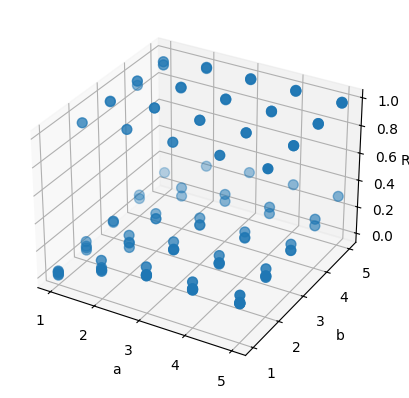

In [14]:
# prompt: Write pds to CSV.
# Then write code to open CSV and create a 3-d representation with axis a, b, rsq, and d is the color of the bubbles

import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming 'pds' DataFrame is already created as in your code


# Read the CSV file
df = pd.read_csv('model_results.csv')

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
#ax.scatter(df['a'], df['b'], df['RSQ'], c=df['d'], s=50)
ax.scatter(df['a'], df['b'], df['RSQ'], s=50)

# Set axis labels
ax.set_xlabel('a')
ax.set_ylabel('b')
ax.set_zlabel('RSQ')

# Customize colorbar (optional)
# plt.colorbar(label='d (Delay)')

# Show the plot
plt.show()


In [15]:
import plotly.express as px

# Load your CSV file
df = pd.read_csv('model_results.csv')

# Create interactive scatter plot
fig = px.scatter_3d(df, x='a', y='b', z='RSQ', color='AIC', size="d",
                    #animation_frame="d",
                    title='R2 for different structures',
                    labels={'A': 'A', 'B': 'B', 'RSQ': 'RSQ', 'AIC': 'AIC'},
                    #range_color=[0,4],
                    range_x=[0.5,5.5],
                    range_y=[-0.5,5.5],
                    #range_z=[0.0, 1.0],
                    hover_data={"Structure":True, "RSQ":True, "AIC":True, "a":False,"b":False, "d":False}
                    #color_continuous_scale=px.colors.sequential.Plasma
                    )

fig.update_traces(marker=dict(size=3))

# Update axes to show only integer values from 0 to 4
fig.update_layout(
    scene=dict(
        xaxis=dict(tickmode='linear', tick0=0, dtick=1),
        yaxis=dict(tickmode='linear', tick0=0, dtick=1)
    )
)

fig.update_layout(
    scene=dict(
        xaxis_title='a',
        yaxis_title='b',
        zaxis_title='R2',),
    width=800,
    height=800,
    margin=dict(l=0, r=0, b=0, t=0)
)


# Show the plot
fig.show()

In [16]:
combined_score = [0.5 * rsq + 0.5 * (1 - (aic - min(AIC)) / (max(AIC) - min(AIC))) for rsq, aic in zip(RSQ, AIC)]
rsq_b = max(RSQ)


best_model_index = combined_score.index(max(combined_score))
best_structure = Structure[best_model_index]
print(f"Best model structure: {best_structure}")



Best model structure: (2, 2, 4)


Step 3.2: Find the optimal model structure

In [17]:
# 3.1: Inspect model evaluations to determine the optimal model structure (print them below)

Present optimal model

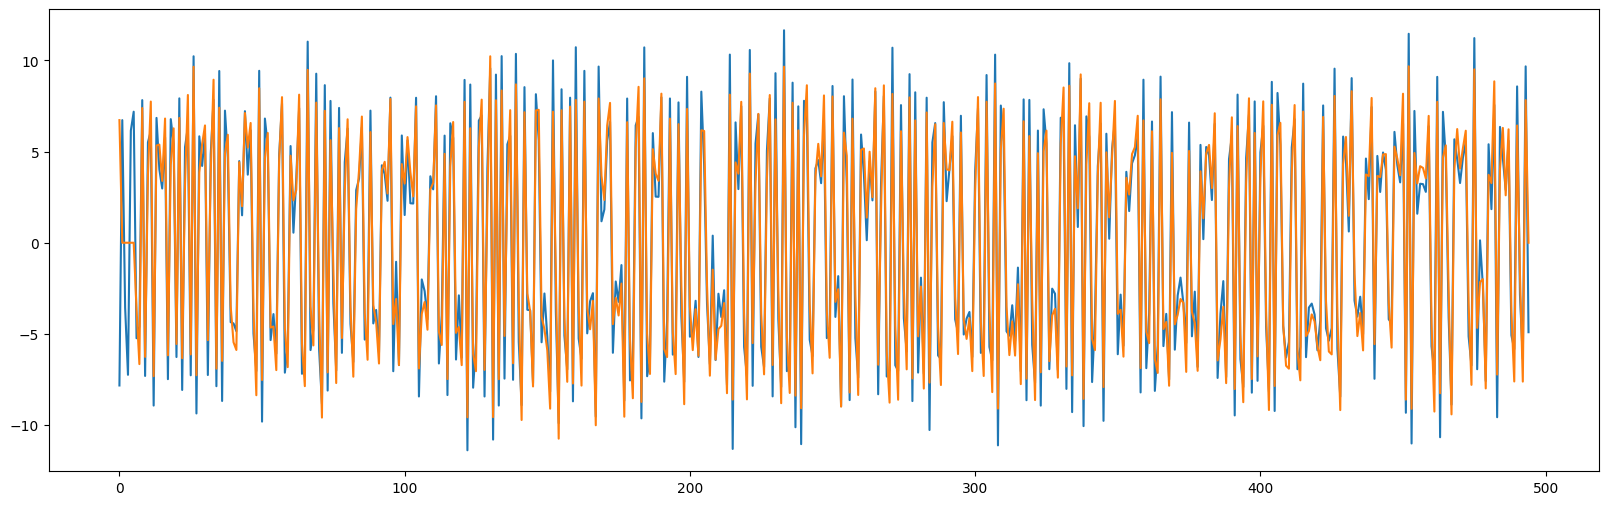

In [18]:
# Simulate model
# Attention! make sure the order of the parameters in the formula is correct, to check which parameters correspond to the endogenous and exogenous variables
# print the relative dataframe and check its columns

opt_na = 1
opt_nb = 2
opt_d = 4

opt_y_pred, opt_y_sim, opt_params, opt_rsq, opt_aic = calcmodel(opt_na, opt_nb, opt_d)

e = np.random.randn(n, 1) * np.sqrt(0.16)


#print('\nModel #{} \nwith {} a parameters, {} b parameters and {} time delay'.format(model_count,na,nb,d))

start_y = max(opt_na, opt_nb + opt_d)


plt.figure(figsize=(20,6))
plt.plot(y[start_y-1:])
plt.plot(opt_y_sim)


In [19]:
opt_y_sim.shape


(495, 1)

Step 4: Model validation

In [20]:
# Assuming parameters, y, u, number_a, number_b, and d are defined earlier in the code

n = len(y)  # Set 'n' to the length of 'y' to match its size
ysim_val = np.zeros((n, 1))
e = np.random.randn(n, 1) * np.sqrt(0.16)  # Noise vector e~N(0,0.16)

start_index = max(number_b + d, number_a)  # Adjusted start_index calculation
print(parameters[:number_a])
# Simulation loop
for k in range(start_index, n):
    ysim_val[k] = (-parameters[:number_a] * ysim_val[k - 1]) + parameters[1] * u[k - d] + parameters[:number_b] * u[k - 1 - d] + e[k]

# Ensure matching shapes by recalculating slices after start_index
y_trimmed = y[start_index:]
ysim_val_trimmed = ysim_val[start_index:]

# Calculate R-squared
SS_res = np.sum((y_trimmed - ysim_val_trimmed) ** 2)
SS_tot = np.sum((y_trimmed - np.mean(y_trimmed)) ** 2)
rsq = 1 - (SS_res / SS_tot)

# Calculate AIC
n_val = len(y_trimmed)  # Number of validation data points
k = len(parameters)      # Number of parameters
aic = 2 * k + n_val * np.log(SS_res / n_val)

print("R-squared:", rsq)
print("AIC:", aic)

# Plotting
plt.figure(figsize=(20, 6))
plt.plot(y, label='y')
plt.plot(ysim_val, label='ysim_val')
plt.legend(['y', 'ysim_val'])
plt.show()


NameError: name 'parameters' is not defined